### Import all the required Python packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn import grid_search
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

%matplotlib inline

/Users/marcus/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marcus/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Few Useful functions that we will be using down the line

In [2]:
# Few useful functions

'''
Takes an image and a list of top left and bottom right corners to draw boxes on the image
'''
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick);
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes


'''Resize an image '''
def image_resize(img, size):
    resized_img = cv2.resize(img, size)
    return resized_img

# Get feature vector of an image

def getFeatureVector(img):
    feature_vec = img.ravel()
    return feature_vec


''' Create training and test sets'''

def createTrainingAndTest(car_features, notcar_features, rand_state):
    # Define a labels vector based on features lists
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(notcar_features))))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler


'''Convert image to color '''
def convert_color(img, conv='YCrCb'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    


#### Load Training and test data

In [3]:
notcars = glob.glob('non-vehicles/*/*.png')
cars = glob.glob('vehicles/*/*.png')

print(len(notcars))
print(len(cars))

8968
8792


#### Print few samples of data available

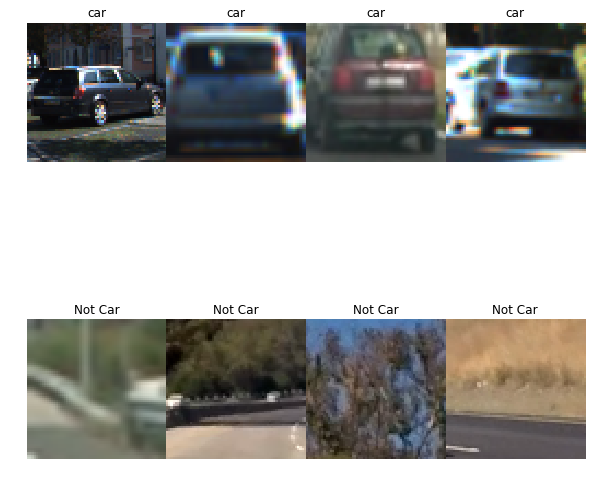

In [4]:
fig, axs = plt.subplots(2,4, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in np.arange(4):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    axs[i].imshow(img)
for i in np.arange(4,8):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not Car', fontsize=12)
    axs[i].imshow(img)

#### Test Image

Below I am importing an image to test my pipeline

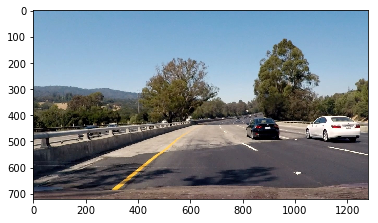

In [5]:
image = mpimg.imread('test_images/test4.jpg')
plt.imshow(image)

#### Spacial Binning of the image

Below function performs spacial binning for the image. 

In [16]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space == 'RGB':
        img_color_space = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    elif color_space == 'HSV':
        img_color_space = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        img_color_space = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    # Use cv2.resize().ravel() to create the feature vector
    resized_img = cv2.resize(img_color_space, size)
    features = resized_img.ravel() # Remove this line!
    # Return the feature vector
    return features

#### Below function returns color histogram features of the image

In [17]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### HOG Features

This function will extract the HOG features of the image

In [18]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
            visualise=True, feature_vector=feature_vec)

        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
            visualise=False, feature_vector=feature_vec)
        return features

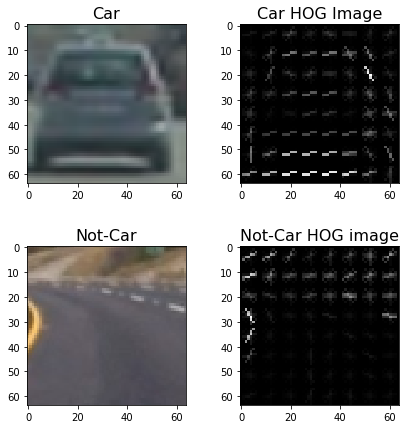

In [19]:
car = mpimg.imread(cars[4])
_, car_dst = get_hog_features(car[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar = mpimg.imread(notcars[4])
_, noncar_dst = get_hog_features(notcar[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Display the HOG image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car)
ax1.set_title('Car', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG Image', fontsize=16)
ax3.imshow(notcar)
ax3.set_title('Not-Car', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Not-Car HOG image', fontsize=16)

#### Function to extract features

In [20]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Prepare Training and Test data 

Below section prepares the Training and Test data from the image names loaded earlier

In [21]:
''' This function will get image features and create Training and test sets'''
def createTrainingAndTest(car_features, notcar_features, rand_state):
    # Define a labels vector based on features lists
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(notcar_features))))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler

In [22]:
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 720]  # Min and max in y to search in slide_window()

In [23]:
car_features = extract_features(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)

from sklearn.utils import shuffle
car_features = shuffle(car_features, random_state=42)
notcar_features = shuffle(notcar_features, random_state=42)

In [24]:
#rand_state = np.random.randint(0, 100)
rand_state = 42

X_train, X_test, y_train, y_test, X_scaler = createTrainingAndTest(car_features, notcar_features, rand_state)
print("Training Data:")
print(len(X_train))
print("Test Data:")
print(len(X_test))

Training Data:
14208
Test Data:
3552


#### Training the classifier

In this section, i am training a LinearSVC classifier using the training data created in the previous section

In [25]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

13.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


The test accuracy of the model is 98.96. Now this model will be used to detect cars in the image in the next section. 

#### Function to detect cars using the classifier

First, I am defining few helper functions to make the task easier. These functions will use heatmaps and threasholds to weed out the false possitives and multiple detections.  
 

In [26]:
def add_heat(bbox_list):
    # Iterate through list of bboxes
    heatmap = np.zeros_like(image[:, :, 0]).astype(np.float)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    # Return the image
    return img

Below function will utilize the previously trained LinearSVC to detect the Cars. This will use a sliding window method for a pre defined area of the image to detect the possible cars.

In [27]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    image = img.astype(np.float32) / 255

    img_tosearch = image[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
               np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(all_features)
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                boxes.append(((xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    heat = add_heat(boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    return final_image, draw_img

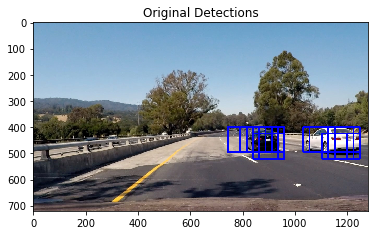

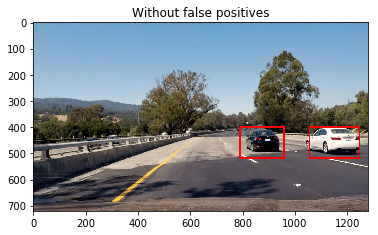

In [28]:
ystart = 400
ystop = 720
scale = 1.5

final_img, draw_image = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.title('Original Detections')
plt.imshow(draw_image)
plt.show()

plt.title('Without false positives')
plt.imshow(final_img)
plt.show()

Lets try few more test images

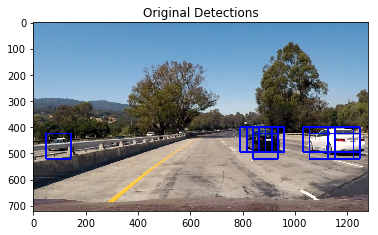

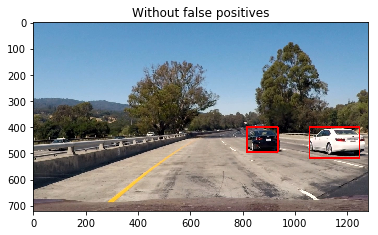

In [29]:
image1 = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

final_img, draw_image = find_cars(image1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.title('Original Detections')
plt.imshow(draw_image)
plt.show()

plt.title('Without false positives')
plt.imshow(final_img)
plt.show()

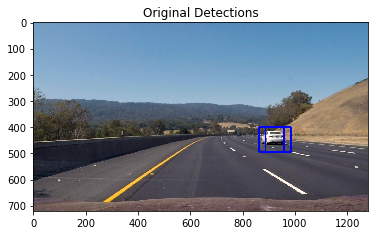

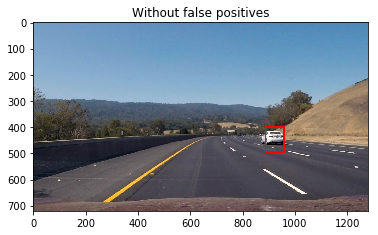

In [30]:
image2 = mpimg.imread('test_images/test3.jpg')
plt.imshow(image)

final_img, draw_image = find_cars(image2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.title('Original Detections')
plt.imshow(draw_image)
plt.show()

plt.title('Without false positives')
plt.imshow(final_img)
plt.show()

In the next example I am trying out an image that does not have a car

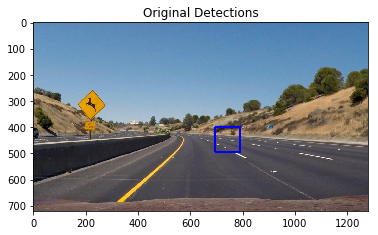

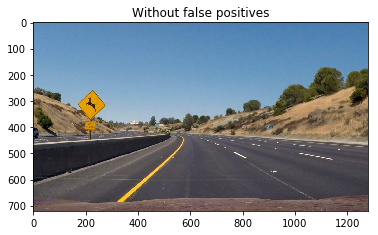

In [31]:
image1 = mpimg.imread('test_images/test2.jpg')
plt.imshow(image)

final_img, draw_image = find_cars(image1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.title('Original Detections')
plt.imshow(draw_image)
plt.show()

plt.title('Without false positives')
plt.imshow(final_img)
plt.show()

#### Defining the Image Pipeline

As the last step pf this process, I am creating the function to process the each image of the video feed. This perfoms all the steps we did to a single image on every frome of the video.

In [32]:
def process_image(image):
    ystart = 400
    ystop = 720
    scale = 1.5
    final_img, draw_image = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return final_img


In [33]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:11<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 33.6 s, sys: 530 ms, total: 34.1 s
Wall time: 11.9 s


In [ ]:
test_out_file = 'proj_video_out_1.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

The bounding box in this first try is little shaky. So I am going to use historical average in order to smooth the frames out. For this I am using a class to save the historical data for last 10 iterations and and get the average of that to draw the  rectangle. 

In [108]:
# Define a class to receive the rectangles of each Car detection
class Detections():
    def __init__(self):
        # Rectangles averaged over the last 10 iterations
        self.best_boundary = [((0,0),(0,0))]
        # Rectangles of the last n iterations
        self.recent_bounds = deque(maxlen=10)
        self.recent_mean_bounds = deque(maxlen=10)
        self.recent_lengths = deque(maxlen=10)
        
    def add_best_bounds(self, boundaries):
        self.recent_bounds.append(boundaries)
        self.recent_lengths.append(len(boundaries))
        mean_len = np.mean(self.recent_lengths, dtype=np.int32)
        self.recent_mean_bounds =  deque(maxlen=10)
        for bound in self.recent_bounds:
            if len(bound) >= mean_len:
                self.recent_mean_bounds.append(bound[:mean_len])
        self.best_boundary = np.mean(self.recent_mean_bounds, axis=0, dtype=np.int32)
        #print(self.best_boundary)

In the next section, I am going to modify the find_car method i defined earlier to add the average.

In [109]:
from collections import deque

global detc
dect = Detections()

''' Modifying the draw_labeled_bboxes '''
def draw_labeled_bboxes_v2(img, labels):
    # Iterate through all detected cars
    rectangles = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rectangles.append(bbox)
    
    # add new detections to the global list for average
    if(len(rectangles) > 0):
        dect.add_best_bounds(rectangles)
    
    draw_rects = dect.best_boundary
    
    # Draw the box on the image 
    for item in draw_rects:
        cv2.rectangle(img, tuple(item[0]), tuple(item[1]),(255, 0, 0), 6)
    # Return the image
    return img




def find_cars_v2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    image = img.astype(np.float32) / 255

    img_tosearch = image[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
               np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(all_features)
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                boxes.append(((xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    heat = add_heat(boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    final_image = draw_labeled_bboxes_v2(np.copy(img), labels)
    return final_image, draw_img

In [110]:
def process_image_v2(image):
    ystart = 400
    ystop = 720
    scale = 1.5
    final_img, draw_image = find_cars_v2(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return final_img

deque([[((792, 400), (959, 519)), ((1056, 400), (1247, 519))]], maxlen=10)
2


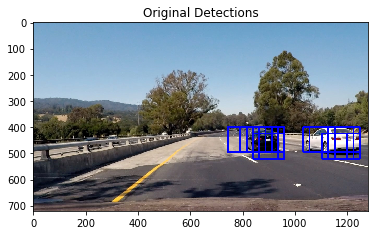

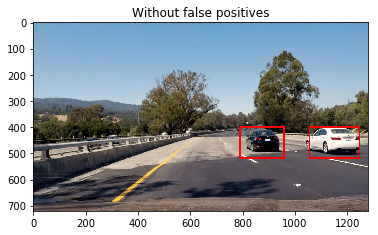

In [98]:
image2 = mpimg.imread('test_images/test4.jpg')
plt.imshow(image)

final_img, draw_image = find_cars_v2(image2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.title('Original Detections')
plt.imshow(draw_image)
plt.show()

plt.title('Without false positives')
plt.imshow(final_img)
plt.show()

In [79]:
test_out_file = 'test_video_out_smooth.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image_v2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_smooth.mp4
[MoviePy] Writing video test_video_out_smooth.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:14,  2.71it/s]

  5%|▌         | 2/39 [00:00<00:13,  2.81it/s]

  8%|▊         | 3/39 [00:01<00:12,  2.91it/s]

 10%|█         | 4/39 [00:01<00:11,  3.01it/s]

 13%|█▎        | 5/39 [00:01<00:11,  3.07it/s]

 15%|█▌        | 6/39 [00:01<00:10,  3.13it/s]

 18%|█▊        | 7/39 [00:02<00:10,  3.15it/s]

 21%|██        | 8/39 [00:02<00:09,  3.13it/s]

 23%|██▎       | 9/39 [00:02<00:09,  3.14it/s]

 26%|██▌       | 10/39 [00:03<00:09,  3.17it/s]

 28%|██▊       | 11/39 [00:03<00:08,  3.16it/s]

 31%|███       | 12/39 [00:03<00:08,  3.16it/s]

 33%|███▎      | 13/39 [00:04<00:08,  3.15it/s]

 36%|███▌      | 14/39 [00:04<00:07,  3.17it/s]

 38%|███▊      | 15/39 [00:04<00:07,  3.15it/s]

 41%|████      | 16/39 [00:05<00:07,  3.18it/s]

 44%|████▎     | 17/39 [00:05<00:06,  3.21it/s]

 46%|████▌     | 18/39 [00:05<00:06,  3.18it/s]

 49%|████▊     | 19/39 [00:06<00:06,  3.17it/s]

 51%|█████▏    | 20/39 [00:06<00:05,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_smooth.mp4 

CPU times: user 35.8 s, sys: 741 ms, total: 36.5 s
Wall time: 12.9 s


In [112]:
dect = Detections()
test_out_file = 'proj_video_out_smooth.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image_v2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video proj_video_out_smooth.mp4
[MoviePy] Writing video proj_video_out_smooth.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<06:43,  3.12it/s]




  0%|          | 2/1261 [00:00<06:34,  3.19it/s]




  0%|          | 3/1261 [00:00<06:27,  3.24it/s]




  0%|          | 4/1261 [00:01<06:23,  3.28it/s]




  0%|          | 5/1261 [00:01<06:21,  3.29it/s]




  0%|          | 6/1261 [00:01<06:20,  3.30it/s]




  1%|          | 7/1261 [00:02<06:16,  3.33it/s]




  1%|          | 8/1261 [00:02<06:15,  3.34it/s]




  1%|          | 9/1261 [00:02<06:12,  3.36it/s]




  1%|          | 10/1261 [00:02<06:13,  3.35it/s]




  1%|          | 11/1261 [00:03<06:11,  3.36it/s]




  1%|          | 12/1261 [00:03<06:11,  3.36it/s]




  1%|          | 13/1261 [00:03<06:10,  3.37it/s]




  1%|          | 14/1261 [00:04<06:08,  3.38it/s]




  1%|          | 15/1261 [00:04<06:08,  3.38it/s]




  1%|▏         | 16/1261 [00:04<06:08,  3.38it/s]




  1%|▏         | 17/1261 [00:05<06:09,  3.37it/s]




  1%|▏         | 18/1261 [00:05<06:10,  3

[MoviePy] Done.
[MoviePy] >>>> Video ready: proj_video_out_smooth.mp4 

CPU times: user 18min 32s, sys: 15.4 s, total: 18min 48s
Wall time: 6min 18s
